In [1]:
import os

import tensorflow as tf
import keras
import matplotlib.pyplot as plt

E0000 00:00:1732047810.332234   25429 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732047810.376916   25429 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
def convert_model(_model, path):
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()

    with open(path, 'wb') as f:
        f.write(tflite_model)

def generate_cpp(path):
    var_names = (
        path.replace("/", "_").replace(".", "_"),
        path.replace("/", "_").replace(".", "_") + "_len"
    )
    cpp_path = path.replace(".tflite", ".cpp")
    os.system(f'xxd -i {path} > {cpp_path}')

    with open(cpp_path, 'r') as f:
        cpp_text = f.read()

    h_path = cpp_path.replace(".cpp", ".h")
    with open(h_path, 'w') as f:
        f.write(f"extern unsigned char {var_names[0]}[];\n")
        f.write(f"extern unsigned int {var_names[1]};")

    h_name = h_path.split("/")[-1]
    with open(cpp_path, "w") as f:
        f.write(f'#include "{h_name}"\n\n' + cpp_text)

def get_evaluation(model, history, epochs, x_test, y_test, path):
    train_loss = history['loss']
    val_loss = history['val_loss']

    train_acc = history['sparse_categorical_accuracy']
    val_acc = history['val_sparse_categorical_accuracy']

    figure = plt.figure()
    plt.plot(range(1, 1 + epochs), train_loss, label='train loss')
    plt.plot(range(1, 1 + epochs), val_loss, label='validation loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.savefig(path + "/loss.png")
    plt.close(figure)

    figure = plt.figure()
    plt.plot(range(1, 1 + epochs), train_acc, label='train acc')
    plt.plot(range(1, 1 + epochs), val_acc, label='validation acc')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()
    plt.savefig(path + "/accuracy.png")
    plt.close(figure)

    print(model.evaluate(x_test, y_test))

# MNIST Dataset

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

In [3]:
x_train = x_train.reshape(60000, 784).astype("float32") / 255
x_test = x_test.reshape(10000, 784).astype("float32") / 255

y_train = y_train.astype("float32")
y_test = y_test.astype("float32")

x_val = x_train[-10000:]
y_val = y_train[-10000:]
x_train = x_train[:-10000]
y_train = y_train[:-10000]

In [29]:
epochs = 3
lr = 0.001

In [28]:
filter_n = 10
filter_start = 1
filter_size_n = 3

conv_x_train = x_train.reshape((50000, 28, 28, 1))
conv_x_val = x_val.reshape((10000, 28, 28, 1))
conv_x_test = x_test.reshape((10000, 28, 28, 1))

conv_y_train = y_train
conv_y_val = y_val
conv_y_test = y_test

for i in range(filter_start, filter_start + filter_n):
    for j in range(1, 1 + filter_size_n):
        model = keras.models.Sequential([
            keras.layers.Conv2D(i, kernel_size=(j, j), activation='relu', input_shape=(28, 28, 1)),
            keras.layers.Flatten(),
            keras.layers.Dense(10, activation='softmax')
        ])
        model.compile(
            optimizer=keras.optimizers.Adam(lr),
            loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=[keras.metrics.SparseCategoricalAccuracy()],
        )

        history = model.fit(
            conv_x_train,
            conv_y_train,
            epochs=epochs,
            validation_data=(conv_x_val, conv_y_val)
        )
        history = history.history

        path = f"models/conv{i}_{j}x{j}_dense"
        if not os.path.isdir(path):
            os.makedirs(path)

        get_evaluation(model, history, epochs, conv_x_test, conv_y_test, path)

        path += f"/conv{i}_{j}x{j}_dense.tflite"
        convert_model(model, path)
        generate_cpp(path)

In [33]:
for i in range(10, 100, 10):
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(i, activation='relu'),
        keras.layers.Dense(10, activation='softmax')
    ])
    model.compile(
        optimizer=keras.optimizers.Adam(lr),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras.metrics.SparseCategoricalAccuracy()],
    )

    history = model.fit(
        x_train,
        y_train,
        epochs=epochs,
        validation_data=(x_val, y_val)
    )
    history = history.history

    path = f"models/flatten_dense{i}_dense"
    if not os.path.isdir(path):
        os.makedirs(path)

    get_evaluation(model, history, epochs, x_test, y_test, path)

    path += f"/flatten_dense{i}_dense.tflite"
    convert_model(model, path)
    generate_cpp(path)

Epoch 1/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 977us/step - loss: 0.9540 - sparse_categorical_accuracy: 0.7281 - val_loss: 0.3204 - val_sparse_categorical_accuracy: 0.9110
Epoch 2/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 663us/step - loss: 0.3291 - sparse_categorical_accuracy: 0.9053 - val_loss: 0.2806 - val_sparse_categorical_accuracy: 0.9221
Epoch 3/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 765us/step - loss: 0.2917 - sparse_categorical_accuracy: 0.9167 - val_loss: 0.2647 - val_sparse_categorical_accuracy: 0.9286
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 467us/step - loss: 0.3104 - sparse_categorical_accuracy: 0.9120
[0.27602845430374146, 0.9218999743461609]
INFO:tensorflow:Assets written to: /tmp/tmpcjmopdn8/assets


INFO:tensorflow:Assets written to: /tmp/tmpcjmopdn8/assets


Saved artifact at '/tmp/tmpcjmopdn8'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 784), dtype=tf.float32, name='keras_tensor_36')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  132877568867216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132877568868176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132877568867600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132877568867792: TensorSpec(shape=(), dtype=tf.resource, name=None)
Epoch 1/3


W0000 00:00:1732035798.452066    3792 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1732035798.452076    3792 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
/home/moriogai/.virtualenvs/CVEsp32/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 898us/step - loss: 0.7161 - sparse_categorical_accuracy: 0.8005 - val_loss: 0.2442 - val_sparse_categorical_accuracy: 0.9314
Epoch 2/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 541us/step - loss: 0.2477 - sparse_categorical_accuracy: 0.9282 - val_loss: 0.2051 - val_sparse_categorical_accuracy: 0.9416
Epoch 3/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 569us/step - loss: 0.2041 - sparse_categorical_accuracy: 0.9410 - val_loss: 0.1853 - val_sparse_categorical_accuracy: 0.9490
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - loss: 0.2231 - sparse_categorical_accuracy: 0.9379
[0.19138400256633759, 0.9463000297546387]
INFO:tensorflow:Assets written to: /tmp/tmpyor8tj9q/assets


INFO:tensorflow:Assets written to: /tmp/tmpyor8tj9q/assets


Saved artifact at '/tmp/tmpyor8tj9q'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 784), dtype=tf.float32, name='keras_tensor_40')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  132877567386320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132877567386704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132877568866832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132877568866448: TensorSpec(shape=(), dtype=tf.resource, name=None)
Epoch 1/3


W0000 00:00:1732035802.866013    3792 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1732035802.866025    3792 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
/home/moriogai/.virtualenvs/CVEsp32/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 914us/step - loss: 0.6424 - sparse_categorical_accuracy: 0.8158 - val_loss: 0.2236 - val_sparse_categorical_accuracy: 0.9354
Epoch 2/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 971us/step - loss: 0.2276 - sparse_categorical_accuracy: 0.9337 - val_loss: 0.1725 - val_sparse_categorical_accuracy: 0.9496
Epoch 3/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 562us/step - loss: 0.1762 - sparse_categorical_accuracy: 0.9496 - val_loss: 0.1556 - val_sparse_categorical_accuracy: 0.9529
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 379us/step - loss: 0.1766 - sparse_categorical_accuracy: 0.9491
[0.16127485036849976, 0.953000009059906]
INFO:tensorflow:Assets written to: /tmp/tmpohalm0bl/assets


INFO:tensorflow:Assets written to: /tmp/tmpohalm0bl/assets


Saved artifact at '/tmp/tmpohalm0bl'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 784), dtype=tf.float32, name='keras_tensor_44')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  132877835266064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132879444146128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132879444139600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132879900053328: TensorSpec(shape=(), dtype=tf.resource, name=None)
Epoch 1/3


W0000 00:00:1732035807.833270    3792 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1732035807.833279    3792 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
/home/moriogai/.virtualenvs/CVEsp32/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 975us/step - loss: 0.5788 - sparse_categorical_accuracy: 0.8401 - val_loss: 0.2117 - val_sparse_categorical_accuracy: 0.9395
Epoch 2/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 757us/step - loss: 0.1936 - sparse_categorical_accuracy: 0.9437 - val_loss: 0.1569 - val_sparse_categorical_accuracy: 0.9556
Epoch 3/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 620us/step - loss: 0.1466 - sparse_categorical_accuracy: 0.9579 - val_loss: 0.1359 - val_sparse_categorical_accuracy: 0.9605
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 377us/step - loss: 0.1606 - sparse_categorical_accuracy: 0.9523
[0.14068761467933655, 0.9577999711036682]
INFO:tensorflow:Assets written to: /tmp/tmpnswfvce5/assets


INFO:tensorflow:Assets written to: /tmp/tmpnswfvce5/assets


Saved artifact at '/tmp/tmpnswfvce5'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 784), dtype=tf.float32, name='keras_tensor_48')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  132877570037648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132877840310800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132877570043984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132877840314256: TensorSpec(shape=(), dtype=tf.resource, name=None)
Epoch 1/3


W0000 00:00:1732035812.822749    3792 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1732035812.822759    3792 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
/home/moriogai/.virtualenvs/CVEsp32/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.5933 - sparse_categorical_accuracy: 0.8322 - val_loss: 0.1923 - val_sparse_categorical_accuracy: 0.9473
Epoch 2/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 839us/step - loss: 0.1900 - sparse_categorical_accuracy: 0.9452 - val_loss: 0.1468 - val_sparse_categorical_accuracy: 0.9599
Epoch 3/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 760us/step - loss: 0.1370 - sparse_categorical_accuracy: 0.9595 - val_loss: 0.1368 - val_sparse_categorical_accuracy: 0.9613
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step - loss: 0.1573 - sparse_categorical_accuracy: 0.9527
[0.13701650500297546, 0.9602000117301941]
INFO:tensorflow:Assets written to: /tmp/tmprcvi757i/assets


INFO:tensorflow:Assets written to: /tmp/tmprcvi757i/assets


Saved artifact at '/tmp/tmprcvi757i'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 784), dtype=tf.float32, name='keras_tensor_52')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  132877433787536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132877567382672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132877567389392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132877567391696: TensorSpec(shape=(), dtype=tf.resource, name=None)
Epoch 1/3


W0000 00:00:1732035818.509354    3792 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1732035818.509366    3792 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
/home/moriogai/.virtualenvs/CVEsp32/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.5716 - sparse_categorical_accuracy: 0.8398 - val_loss: 0.1832 - val_sparse_categorical_accuracy: 0.9495
Epoch 2/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 874us/step - loss: 0.1817 - sparse_categorical_accuracy: 0.9490 - val_loss: 0.1486 - val_sparse_categorical_accuracy: 0.9581
Epoch 3/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.1217 - sparse_categorical_accuracy: 0.9654 - val_loss: 0.1221 - val_sparse_categorical_accuracy: 0.9651
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 370us/step - loss: 0.1462 - sparse_categorical_accuracy: 0.9566
[0.12244392186403275, 0.9632999897003174]
INFO:tensorflow:Assets written to: /tmp/tmp0rpqcytr/assets


INFO:tensorflow:Assets written to: /tmp/tmp0rpqcytr/assets


Saved artifact at '/tmp/tmp0rpqcytr'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 784), dtype=tf.float32, name='keras_tensor_56')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  132877433785232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132877433792720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132877433782544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132877433796752: TensorSpec(shape=(), dtype=tf.resource, name=None)
Epoch 1/3


W0000 00:00:1732035824.947480    3792 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1732035824.947490    3792 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
/home/moriogai/.virtualenvs/CVEsp32/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.5242 - sparse_categorical_accuracy: 0.8531 - val_loss: 0.1779 - val_sparse_categorical_accuracy: 0.9501
Epoch 2/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.1661 - sparse_categorical_accuracy: 0.9506 - val_loss: 0.1247 - val_sparse_categorical_accuracy: 0.9651
Epoch 3/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 629us/step - loss: 0.1152 - sparse_categorical_accuracy: 0.9668 - val_loss: 0.1122 - val_sparse_categorical_accuracy: 0.9665
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 372us/step - loss: 0.1312 - sparse_categorical_accuracy: 0.9608
[0.11257892847061157, 0.9660000205039978]
INFO:tensorflow:Assets written to: /tmp/tmp93vhez0r/assets


INFO:tensorflow:Assets written to: /tmp/tmp93vhez0r/assets


Saved artifact at '/tmp/tmp93vhez0r'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 784), dtype=tf.float32, name='keras_tensor_60')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  132877302375120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132877302368592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132877302371664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132877302379536: TensorSpec(shape=(), dtype=tf.resource, name=None)
Epoch 1/3


W0000 00:00:1732035830.711220    3792 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1732035830.711230    3792 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
/home/moriogai/.virtualenvs/CVEsp32/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 991us/step - loss: 0.5115 - sparse_categorical_accuracy: 0.8571 - val_loss: 0.1614 - val_sparse_categorical_accuracy: 0.9557
Epoch 2/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 629us/step - loss: 0.1548 - sparse_categorical_accuracy: 0.9547 - val_loss: 0.1153 - val_sparse_categorical_accuracy: 0.9669
Epoch 3/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 901us/step - loss: 0.1025 - sparse_categorical_accuracy: 0.9688 - val_loss: 0.1079 - val_sparse_categorical_accuracy: 0.9694
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step - loss: 0.1225 - sparse_categorical_accuracy: 0.9658
[0.1038479134440422, 0.9708999991416931]
INFO:tensorflow:Assets written to: /tmp/tmp2vnxh_3e/assets


INFO:tensorflow:Assets written to: /tmp/tmp2vnxh_3e/assets


Saved artifact at '/tmp/tmp2vnxh_3e'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 784), dtype=tf.float32, name='keras_tensor_64')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  132877302379728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132877302377232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132877302373200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132877302376464: TensorSpec(shape=(), dtype=tf.resource, name=None)
Epoch 1/3


W0000 00:00:1732035836.003343    3792 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1732035836.003352    3792 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
/home/moriogai/.virtualenvs/CVEsp32/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.4942 - sparse_categorical_accuracy: 0.8627 - val_loss: 0.1754 - val_sparse_categorical_accuracy: 0.9526
Epoch 2/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 606us/step - loss: 0.1523 - sparse_categorical_accuracy: 0.9560 - val_loss: 0.1211 - val_sparse_categorical_accuracy: 0.9654
Epoch 3/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 654us/step - loss: 0.0998 - sparse_categorical_accuracy: 0.9701 - val_loss: 0.1043 - val_sparse_categorical_accuracy: 0.9699
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 374us/step - loss: 0.1142 - sparse_categorical_accuracy: 0.9674
[0.10412027686834335, 0.9700000286102295]
INFO:tensorflow:Assets written to: /tmp/tmpzn21ndtg/assets


INFO:tensorflow:Assets written to: /tmp/tmpzn21ndtg/assets


Saved artifact at '/tmp/tmpzn21ndtg'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 784), dtype=tf.float32, name='keras_tensor_68')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  132877297002896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132877296998288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132877297005968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132877297006736: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1732035841.817275    3792 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1732035841.817288    3792 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.


In [25]:
def get_image_code(x):
    with open("init_input.h", "w") as f:
        f.write('#include "tensorflow/lite/c/common.h" \n\n')
        f.write("void init_input(TfLiteTensor *input);")

    with open("init_input.cpp", "w") as f:
        f.write('#include "init_input.h"\n')
        f.write('#include "tensorflow/lite/c/common.h" \n\n')
        f.write("void init_input(TfLiteTensor *input) {\n")
        for i in range(x.shape[0]):
            for j in range(x.shape[1]):
                f.write(f"\tinput->data.f[{i*x.shape[0] + j}] = {x[i][j]};\n")
        f.write("}\n")

In [26]:
y = y_test[0]
x = x_test[0].reshape((28, 28))
print(y)

7.0


In [27]:
get_image_code(x)

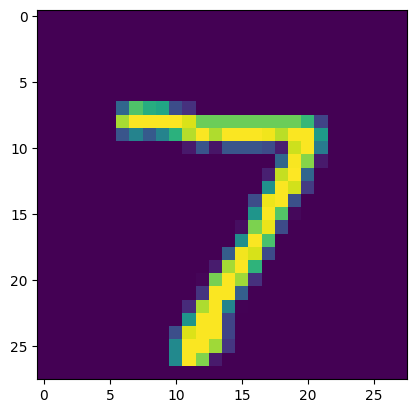

In [34]:
plt.imshow(x)
plt.show()

# MPII Human Pose Dataset

In [4]:
import numpy as np
import pathlib
import scipy.io as spio
from tqdm.auto import tqdm

In [5]:
dataset_url = "https://datasets.d2.mpi-inf.mpg.de/andriluka14cvpr/mpii_human_pose_v1.tar.gz"
archive = keras.utils.get_file(origin=dataset_url, extract=True)
data_dir = pathlib.Path(archive)

In [6]:
path_list = list(data_dir.glob("*/*.jpg"))
n = len(path_list)

In [7]:
mpii_mat = spio.loadmat("mpii_human_pose_v1_u12_1.mat")

In [8]:
mpii_metadata = mpii_mat.get("RELEASE")[0][0]

In [9]:
annolists = mpii_metadata["annolist"][0]
acts = mpii_metadata["act"]

In [11]:
images = []
belong_classes = []

test_images = []

for i in tqdm(range(n)):
    img = keras.utils.load_img(path_list[i])
    img = tf.image.resize(img, (75, 75))

    category = acts[i][0]["cat_name"]
    if category.shape[0] == 0:
        test_images.append(img)
    else:
        images.append(img)
        belong_classes.append(category[0][0])

  0%|          | 0/24984 [00:00<?, ?it/s]

In [12]:
classes_count = list(set(belong_classes))
print(classes_count)
print(len(classes_count))

class_dict = {}
for i in range(len(classes_count)):
    class_dict[classes_count[i]] = i
class_dict

['l', 'w', 'h', 'b', 'm', 'd', 'v', 'o', 't', 'i', 'f', 'c', 'r', 's']
14


{'l': 0,
 'w': 1,
 'h': 2,
 'b': 3,
 'm': 4,
 'd': 5,
 'v': 6,
 'o': 7,
 't': 8,
 'i': 9,
 'f': 10,
 'c': 11,
 'r': 12,
 's': 13}

In [13]:
for i in range(len(belong_classes)):
    belong_classes[i] = class_dict[belong_classes[i]]

In [14]:
belong_classes

[13,
 13,
 13,
 13,
 13,
 13,
 13,
 9,
 9,
 4,
 4,
 4,
 4,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 1,
 9,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 7,
 2,
 7,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 4,
 4,
 0,
 0,
 4,
 4,
 4,
 4,
 4,
 13,
 13,
 13,
 13,
 13,
 12,
 12,
 12,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 7,
 7,
 13,
 13,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 3,
 3,
 3,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 10,
 10,
 10,
 10,
 10,
 10,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 4,
 4,
 4,
 4,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 10,
 10,
 10,
 10,
 10,
 10,
 10

In [24]:
np_images = np.array(images)
np_belong_classes = np.array(belong_classes)

In [64]:
permutation = np.random.permutation(len(np_images))

val_portion = 0.3
train_index = int(np_images.shape[0] * val_portion)

np_train_images = np_images[permutation][:train_index]
np_val_images = np_images[permutation][train_index:]
np_train_classes = np_belong_classes[permutation][:train_index]
np_val_classes = np_belong_classes[permutation][train_index:]

In [38]:
tensor_images = tf.convert_to_tensor(np_images, dtype=tf.float32)
tensor_belong_classes = tf.convert_to_tensor(np_belong_classes, dtype=tf.float32)

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [85]:
epochs = 3
lr = 0.05

In [86]:
np_images.shape

(18032, 75, 75, 3)

In [95]:
filter_n = 10
filter_start = 1
filter_size_n = 5

for i in range(filter_start, filter_start + filter_n):
    for j in range(filter_start, filter_start + filter_size_n):
        model = keras.models.Sequential([
            keras.layers.Conv2D(i, kernel_size=(j, j), activation='relu', input_shape=(75, 75, 3)),
            keras.layers.Flatten(),
            keras.layers.Dense(14, activation='softmax'),
        ])

        model.compile(
            optimizer=keras.optimizers.AdamW(lr),
            loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=[keras.metrics.SparseCategoricalAccuracy()],
        )

        history = model.fit(
            np_train_images,
            np_train_classes,
            epochs=epochs,
            validation_data=(np_val_images, np_val_classes)
        )
        history = history.history

        path = f"models/mpii/mpii_conv{i}_{j}x{j}_dense14"
        if not os.path.isdir(path):
            os.makedirs(path)

        get_evaluation(model, history, epochs, np_val_images, np_val_classes, path)

        path += f"/mpii_conv{i}_{j}x{j}_dense14.tflite"
        convert_model(model, path)
        generate_cpp(path)

Epoch 1/3


/home/moriogai/.virtualenvs/CVEsp32/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/moriogai/.virtualenvs/CVEsp32/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 3471.2800 - sparse_categorical_accuracy: 0.1460 - val_loss: 2.3574 - val_sparse_categorical_accuracy: 0.2028
Epoch 2/3
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.3350 - sparse_categorical_accuracy: 0.1996 - val_loss: 2.3335 - val_sparse_categorical_accuracy: 0.2028
Epoch 3/3
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.3293 - sparse_categorical_accuracy: 0.2017 - val_loss: 2.3222 - val_sparse_categorical_accuracy: 0.2030
395/395 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step - loss: 2.3189 - sparse_categorical_accuracy: 0.2050
[2.322162628173828, 0.20304206013679504]
INFO:tensorflow:Assets written to: /tmp/tmp0in30vok/assets


INFO:tensorflow:Assets written to: /tmp/tmp0in30vok/assets


Saved artifact at '/tmp/tmp0in30vok'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 75, 75, 3), dtype=tf.float32, name='keras_tensor_225')
Output Type:
  TensorSpec(shape=(None, 14), dtype=tf.float32, name=None)
Captures:
  138048046031760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138048046029840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138048046032144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138048046035216: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1732050293.665621   25429 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1732050293.665632   25429 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
/home/moriogai/.virtualenvs/CVEsp32/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/3


/home/moriogai/.virtualenvs/CVEsp32/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


170/170 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 647.9752 - sparse_categorical_accuracy: 0.1575 - val_loss: 2.2845 - val_sparse_categorical_accuracy: 0.2038
Epoch 2/3
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.2942 - sparse_categorical_accuracy: 0.1994 - val_loss: 2.2842 - val_sparse_categorical_accuracy: 0.2038
Epoch 3/3
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.3000 - sparse_categorical_accuracy: 0.1986 - val_loss: 2.2837 - val_sparse_categorical_accuracy: 0.2038
395/395 ━━━━━━━━━━━━━━━━━━━━ 0s 839us/step - loss: 2.2769 - sparse_categorical_accuracy: 0.2059
[2.283679246902466, 0.20383426547050476]
INFO:tensorflow:Assets written to: /tmp/tmp7aw4hzz0/assets


INFO:tensorflow:Assets written to: /tmp/tmp7aw4hzz0/assets


Saved artifact at '/tmp/tmp7aw4hzz0'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 75, 75, 3), dtype=tf.float32, name='keras_tensor_229')
Output Type:
  TensorSpec(shape=(None, 14), dtype=tf.float32, name=None)
Captures:
  138048046032720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138048050216208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138048050212368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138048050212752: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1732050298.937018   25429 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1732050298.937029   25429 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
/home/moriogai/.virtualenvs/CVEsp32/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/3


/home/moriogai/.virtualenvs/CVEsp32/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


170/170 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 3.5987 - sparse_categorical_accuracy: 0.1723 - val_loss: 2.2843 - val_sparse_categorical_accuracy: 0.2039
Epoch 2/3
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.2960 - sparse_categorical_accuracy: 0.1886 - val_loss: 2.2790 - val_sparse_categorical_accuracy: 0.2039
Epoch 3/3
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.3048 - sparse_categorical_accuracy: 0.1942 - val_loss: 2.2842 - val_sparse_categorical_accuracy: 0.2039
395/395 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.2752 - sparse_categorical_accuracy: 0.2057
[2.2841796875, 0.20391349494457245]
INFO:tensorflow:Assets written to: /tmp/tmpd0yzpw8j/assets


INFO:tensorflow:Assets written to: /tmp/tmpd0yzpw8j/assets


Saved artifact at '/tmp/tmpd0yzpw8j'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 75, 75, 3), dtype=tf.float32, name='keras_tensor_233')
Output Type:
  TensorSpec(shape=(None, 14), dtype=tf.float32, name=None)
Captures:
  138048055587856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138048055582480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138048055588240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138048055584784: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1732050304.751446   25429 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1732050304.751457   25429 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
/home/moriogai/.virtualenvs/CVEsp32/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/3


/home/moriogai/.virtualenvs/CVEsp32/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


170/170 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 25.6921 - sparse_categorical_accuracy: 0.1997 - val_loss: 2.2869 - val_sparse_categorical_accuracy: 0.2039
Epoch 2/3
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.2869 - sparse_categorical_accuracy: 0.2003 - val_loss: 2.2828 - val_sparse_categorical_accuracy: 0.2039
Epoch 3/3
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.2877 - sparse_categorical_accuracy: 0.1999 - val_loss: 2.2827 - val_sparse_categorical_accuracy: 0.2039
395/395 ━━━━━━━━━━━━━━━━━━━━ 0s 911us/step - loss: 2.2750 - sparse_categorical_accuracy: 0.2060
[2.282651424407959, 0.20391349494457245]
INFO:tensorflow:Assets written to: /tmp/tmpm5j9m_qf/assets


INFO:tensorflow:Assets written to: /tmp/tmpm5j9m_qf/assets


Saved artifact at '/tmp/tmpm5j9m_qf'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 75, 75, 3), dtype=tf.float32, name='keras_tensor_237')
Output Type:
  TensorSpec(shape=(None, 14), dtype=tf.float32, name=None)
Captures:
  138048055587088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138049850775248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138049652096272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138049321638160: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1732050310.551633   25429 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1732050310.551644   25429 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
/home/moriogai/.virtualenvs/CVEsp32/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/3


/home/moriogai/.virtualenvs/CVEsp32/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


170/170 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 4.5454 - sparse_categorical_accuracy: 0.1897 - val_loss: 2.2836 - val_sparse_categorical_accuracy: 0.2039
Epoch 2/3
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.2833 - sparse_categorical_accuracy: 0.2060 - val_loss: 2.2865 - val_sparse_categorical_accuracy: 0.2039
Epoch 3/3
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.2929 - sparse_categorical_accuracy: 0.2040 - val_loss: 2.2785 - val_sparse_categorical_accuracy: 0.2039
395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 2.2716 - sparse_categorical_accuracy: 0.2060
[2.2784910202026367, 0.20391349494457245]
INFO:tensorflow:Assets written to: /tmp/tmp0o_0vsn7/assets


INFO:tensorflow:Assets written to: /tmp/tmp0o_0vsn7/assets


Saved artifact at '/tmp/tmp0o_0vsn7'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 75, 75, 3), dtype=tf.float32, name='keras_tensor_241')
Output Type:
  TensorSpec(shape=(None, 14), dtype=tf.float32, name=None)
Captures:
  138048242745424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138048912087504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138048057110224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138048057101200: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1732050317.031212   25429 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1732050317.031223   25429 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
/home/moriogai/.virtualenvs/CVEsp32/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/3


/home/moriogai/.virtualenvs/CVEsp32/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 24.6122 - sparse_categorical_accuracy: 0.1695 - val_loss: 2.2817 - val_sparse_categorical_accuracy: 0.2039
Epoch 2/3
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.2856 - sparse_categorical_accuracy: 0.2062 - val_loss: 2.2797 - val_sparse_categorical_accuracy: 0.2039
Epoch 3/3
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.2959 - sparse_categorical_accuracy: 0.1963 - val_loss: 2.2888 - val_sparse_categorical_accuracy: 0.2039
395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 2.2836 - sparse_categorical_accuracy: 0.2060
[2.288752317428589, 0.20391349494457245]
INFO:tensorflow:Assets written to: /tmp/tmpugqfmqj1/assets


INFO:tensorflow:Assets written to: /tmp/tmpugqfmqj1/assets


Saved artifact at '/tmp/tmpugqfmqj1'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 75, 75, 3), dtype=tf.float32, name='keras_tensor_245')
Output Type:
  TensorSpec(shape=(None, 14), dtype=tf.float32, name=None)
Captures:
  138048057110416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138048057112528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138048057103312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138048057113488: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1732050321.624815   25429 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1732050321.624825   25429 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
/home/moriogai/.virtualenvs/CVEsp32/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/3


/home/moriogai/.virtualenvs/CVEsp32/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 6.8786 - sparse_categorical_accuracy: 0.1793 - val_loss: 2.2841 - val_sparse_categorical_accuracy: 0.2039
Epoch 2/3
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.2806 - sparse_categorical_accuracy: 0.2166 - val_loss: 2.2801 - val_sparse_categorical_accuracy: 0.2039
Epoch 3/3
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.2847 - sparse_categorical_accuracy: 0.2019 - val_loss: 2.2813 - val_sparse_categorical_accuracy: 0.2039
395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.2737 - sparse_categorical_accuracy: 0.2060
[2.2812750339508057, 0.20391349494457245]
INFO:tensorflow:Assets written to: /tmp/tmp7e012gq9/assets


INFO:tensorflow:Assets written to: /tmp/tmp7e012gq9/assets


Saved artifact at '/tmp/tmp7e012gq9'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 75, 75, 3), dtype=tf.float32, name='keras_tensor_249')
Output Type:
  TensorSpec(shape=(None, 14), dtype=tf.float32, name=None)
Captures:
  138048037979152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138048037981264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138048037990480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138048037992016: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1732050327.133277   25429 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1732050327.133287   25429 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
/home/moriogai/.virtualenvs/CVEsp32/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/3


/home/moriogai/.virtualenvs/CVEsp32/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


170/170 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 16.9961 - sparse_categorical_accuracy: 0.1749 - val_loss: 2.2808 - val_sparse_categorical_accuracy: 0.2039
Epoch 2/3
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.2818 - sparse_categorical_accuracy: 0.2078 - val_loss: 2.2824 - val_sparse_categorical_accuracy: 0.2039
Epoch 3/3
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.2900 - sparse_categorical_accuracy: 0.1983 - val_loss: 2.2839 - val_sparse_categorical_accuracy: 0.2039
395/395 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step - loss: 2.2759 - sparse_categorical_accuracy: 0.2060
[2.2839484214782715, 0.20391349494457245]
INFO:tensorflow:Assets written to: /tmp/tmpcpj9b6by/assets


INFO:tensorflow:Assets written to: /tmp/tmpcpj9b6by/assets


Saved artifact at '/tmp/tmpcpj9b6by'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 75, 75, 3), dtype=tf.float32, name='keras_tensor_253')
Output Type:
  TensorSpec(shape=(None, 14), dtype=tf.float32, name=None)
Captures:
  138047705843856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138047705853072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138047705849232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138047705850768: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1732050332.239422   25429 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1732050332.239433   25429 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
/home/moriogai/.virtualenvs/CVEsp32/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/3


/home/moriogai/.virtualenvs/CVEsp32/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


170/170 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 45.1365 - sparse_categorical_accuracy: 0.1927 - val_loss: 2.2801 - val_sparse_categorical_accuracy: 0.2039
Epoch 2/3
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.2988 - sparse_categorical_accuracy: 0.2056 - val_loss: 2.2839 - val_sparse_categorical_accuracy: 0.2039
Epoch 3/3
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.2743 - sparse_categorical_accuracy: 0.2018 - val_loss: 2.2858 - val_sparse_categorical_accuracy: 0.2039
395/395 ━━━━━━━━━━━━━━━━━━━━ 0s 782us/step - loss: 2.2754 - sparse_categorical_accuracy: 0.2060
[2.2858269214630127, 0.20391349494457245]
INFO:tensorflow:Assets written to: /tmp/tmpj77c13rr/assets


INFO:tensorflow:Assets written to: /tmp/tmpj77c13rr/assets


Saved artifact at '/tmp/tmpj77c13rr'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 75, 75, 3), dtype=tf.float32, name='keras_tensor_257')
Output Type:
  TensorSpec(shape=(None, 14), dtype=tf.float32, name=None)
Captures:
  138047705845200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138047705854416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138047705855568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138047705844432: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1732050337.745762   25429 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1732050337.745774   25429 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
/home/moriogai/.virtualenvs/CVEsp32/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/3


/home/moriogai/.virtualenvs/CVEsp32/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


170/170 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 9.6544 - sparse_categorical_accuracy: 0.1733 - val_loss: 2.2878 - val_sparse_categorical_accuracy: 0.2039
Epoch 2/3
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.3050 - sparse_categorical_accuracy: 0.2031 - val_loss: 2.2800 - val_sparse_categorical_accuracy: 0.2039
Epoch 3/3
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.2878 - sparse_categorical_accuracy: 0.2061 - val_loss: 2.2889 - val_sparse_categorical_accuracy: 0.2039
395/395 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.2828 - sparse_categorical_accuracy: 0.2060
[2.2889299392700195, 0.20391349494457245]
INFO:tensorflow:Assets written to: /tmp/tmpp_2m3uwr/assets


INFO:tensorflow:Assets written to: /tmp/tmpp_2m3uwr/assets


Saved artifact at '/tmp/tmpp_2m3uwr'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 75, 75, 3), dtype=tf.float32, name='keras_tensor_261')
Output Type:
  TensorSpec(shape=(None, 14), dtype=tf.float32, name=None)
Captures:
  138047699100752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138047699102864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138047699094416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138047699099600: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1732050343.252181   25429 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1732050343.252193   25429 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
/home/moriogai/.virtualenvs/CVEsp32/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/3


/home/moriogai/.virtualenvs/CVEsp32/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 5692.6968 - sparse_categorical_accuracy: 0.1671 - val_loss: 2.2797 - val_sparse_categorical_accuracy: 0.2039
Epoch 2/3
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.2950 - sparse_categorical_accuracy: 0.1956 - val_loss: 2.2833 - val_sparse_categorical_accuracy: 0.2038
Epoch 3/3
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.2913 - sparse_categorical_accuracy: 0.2125 - val_loss: 2.2809 - val_sparse_categorical_accuracy: 0.2038
395/395 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step - loss: 2.2739 - sparse_categorical_accuracy: 0.2059
[2.2809133529663086, 0.20383426547050476]
INFO:tensorflow:Assets written to: /tmp/tmpyr5h1uoc/assets


INFO:tensorflow:Assets written to: /tmp/tmpyr5h1uoc/assets


Saved artifact at '/tmp/tmpyr5h1uoc'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 75, 75, 3), dtype=tf.float32, name='keras_tensor_265')
Output Type:
  TensorSpec(shape=(None, 14), dtype=tf.float32, name=None)
Captures:
  138047699103440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138047699103248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138047699098256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138047434593808: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1732050348.481951   25429 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1732050348.481963   25429 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
/home/moriogai/.virtualenvs/CVEsp32/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/3


/home/moriogai/.virtualenvs/CVEsp32/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


170/170 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 1763.9943 - sparse_categorical_accuracy: 0.1581 - val_loss: 2.2841 - val_sparse_categorical_accuracy: 0.2039
Epoch 2/3
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.3008 - sparse_categorical_accuracy: 0.1990 - val_loss: 2.2793 - val_sparse_categorical_accuracy: 0.2039
Epoch 3/3
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.2876 - sparse_categorical_accuracy: 0.2076 - val_loss: 2.2808 - val_sparse_categorical_accuracy: 0.2039
395/395 ━━━━━━━━━━━━━━━━━━━━ 0s 829us/step - loss: 2.2738 - sparse_categorical_accuracy: 0.2060
[2.280822992324829, 0.20391349494457245]
INFO:tensorflow:Assets written to: /tmp/tmpv3f04yyd/assets


INFO:tensorflow:Assets written to: /tmp/tmpv3f04yyd/assets


Saved artifact at '/tmp/tmpv3f04yyd'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 75, 75, 3), dtype=tf.float32, name='keras_tensor_269')
Output Type:
  TensorSpec(shape=(None, 14), dtype=tf.float32, name=None)
Captures:
  138047434597840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138047434591888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138047434601296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138047434597072: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1732050353.784578   25429 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1732050353.784589   25429 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
/home/moriogai/.virtualenvs/CVEsp32/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/3


/home/moriogai/.virtualenvs/CVEsp32/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3.8252 - sparse_categorical_accuracy: 0.1936 - val_loss: 2.2816 - val_sparse_categorical_accuracy: 0.2039
Epoch 2/3
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.2750 - sparse_categorical_accuracy: 0.2019 - val_loss: 2.2832 - val_sparse_categorical_accuracy: 0.2039
Epoch 3/3
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.2899 - sparse_categorical_accuracy: 0.2080 - val_loss: 2.2866 - val_sparse_categorical_accuracy: 0.2039
395/395 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step - loss: 2.2798 - sparse_categorical_accuracy: 0.2060
[2.2865545749664307, 0.20391349494457245]
INFO:tensorflow:Assets written to: /tmp/tmp_jekpze7/assets


INFO:tensorflow:Assets written to: /tmp/tmp_jekpze7/assets


Saved artifact at '/tmp/tmp_jekpze7'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 75, 75, 3), dtype=tf.float32, name='keras_tensor_273')
Output Type:
  TensorSpec(shape=(None, 14), dtype=tf.float32, name=None)
Captures:
  138047434596880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138047434601488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138047434604368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138047302378192: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1732050359.264669   25429 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1732050359.264680   25429 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
/home/moriogai/.virtualenvs/CVEsp32/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/3


/home/moriogai/.virtualenvs/CVEsp32/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


170/170 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 6.7070 - sparse_categorical_accuracy: 0.1598 - val_loss: 2.2856 - val_sparse_categorical_accuracy: 0.2039
Epoch 2/3
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.2923 - sparse_categorical_accuracy: 0.2023 - val_loss: 2.2848 - val_sparse_categorical_accuracy: 0.2039
Epoch 3/3
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.3013 - sparse_categorical_accuracy: 0.2000 - val_loss: 2.2832 - val_sparse_categorical_accuracy: 0.2039
395/395 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.2748 - sparse_categorical_accuracy: 0.2060
[2.28324556350708, 0.20391349494457245]
INFO:tensorflow:Assets written to: /tmp/tmpzljf5x1n/assets


INFO:tensorflow:Assets written to: /tmp/tmpzljf5x1n/assets


Saved artifact at '/tmp/tmpzljf5x1n'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 75, 75, 3), dtype=tf.float32, name='keras_tensor_277')
Output Type:
  TensorSpec(shape=(None, 14), dtype=tf.float32, name=None)
Captures:
  138047302372624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138047302383760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138047302385104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138047302375312: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1732050364.353289   25429 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1732050364.353303   25429 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
/home/moriogai/.virtualenvs/CVEsp32/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/3


/home/moriogai/.virtualenvs/CVEsp32/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


170/170 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 28.6455 - sparse_categorical_accuracy: 0.1994 - val_loss: 2.2796 - val_sparse_categorical_accuracy: 0.2039
Epoch 2/3
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.2942 - sparse_categorical_accuracy: 0.1978 - val_loss: 2.2831 - val_sparse_categorical_accuracy: 0.2039
Epoch 3/3
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.2918 - sparse_categorical_accuracy: 0.2069 - val_loss: 2.2804 - val_sparse_categorical_accuracy: 0.2039
395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.2740 - sparse_categorical_accuracy: 0.2060
[2.280442953109741, 0.20391349494457245]
INFO:tensorflow:Assets written to: /tmp/tmp_r4apmw6/assets


INFO:tensorflow:Assets written to: /tmp/tmp_r4apmw6/assets


Saved artifact at '/tmp/tmp_r4apmw6'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 75, 75, 3), dtype=tf.float32, name='keras_tensor_281')
Output Type:
  TensorSpec(shape=(None, 14), dtype=tf.float32, name=None)
Captures:
  138047101280016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138047101286544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138047101282512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138047101277712: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1732050370.122715   25429 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1732050370.122725   25429 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
/home/moriogai/.virtualenvs/CVEsp32/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/3


/home/moriogai/.virtualenvs/CVEsp32/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2613.8911 - sparse_categorical_accuracy: 0.1603 - val_loss: 2.3449 - val_sparse_categorical_accuracy: 0.2039
Epoch 2/3
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.3888 - sparse_categorical_accuracy: 0.1997 - val_loss: 2.2884 - val_sparse_categorical_accuracy: 0.2040
Epoch 3/3
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.2946 - sparse_categorical_accuracy: 0.2068 - val_loss: 2.2825 - val_sparse_categorical_accuracy: 0.2039
395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 2.2746 - sparse_categorical_accuracy: 0.2060
[2.2825281620025635, 0.20391349494457245]
INFO:tensorflow:Assets written to: /tmp/tmpomd9xhok/assets


INFO:tensorflow:Assets written to: /tmp/tmpomd9xhok/assets


Saved artifact at '/tmp/tmpomd9xhok'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 75, 75, 3), dtype=tf.float32, name='keras_tensor_285')
Output Type:
  TensorSpec(shape=(None, 14), dtype=tf.float32, name=None)
Captures:
  138047434603984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138047434588432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138047434594000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138047434593616: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1732050374.996084   25429 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1732050374.996095   25429 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
/home/moriogai/.virtualenvs/CVEsp32/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/3


/home/moriogai/.virtualenvs/CVEsp32/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


170/170 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 169.4732 - sparse_categorical_accuracy: 0.1862 - val_loss: 2.2909 - val_sparse_categorical_accuracy: 0.2027
Epoch 2/3
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.2730 - sparse_categorical_accuracy: 0.2120 - val_loss: 2.2915 - val_sparse_categorical_accuracy: 0.2025
Epoch 3/3
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.2773 - sparse_categorical_accuracy: 0.1921 - val_loss: 2.2937 - val_sparse_categorical_accuracy: 0.2031
395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.2863 - sparse_categorical_accuracy: 0.2059
[2.2937302589416504, 0.20312128961086273]
INFO:tensorflow:Assets written to: /tmp/tmpawugcfk2/assets


INFO:tensorflow:Assets written to: /tmp/tmpawugcfk2/assets


Saved artifact at '/tmp/tmpawugcfk2'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 75, 75, 3), dtype=tf.float32, name='keras_tensor_289')
Output Type:
  TensorSpec(shape=(None, 14), dtype=tf.float32, name=None)
Captures:
  138047699092304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138047699095184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138047699092112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138047699107088: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1732050380.735809   25429 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1732050380.735820   25429 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
/home/moriogai/.virtualenvs/CVEsp32/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/3


/home/moriogai/.virtualenvs/CVEsp32/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


170/170 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 14.8088 - sparse_categorical_accuracy: 0.1651 - val_loss: 2.2808 - val_sparse_categorical_accuracy: 0.2039
Epoch 2/3
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.3162 - sparse_categorical_accuracy: 0.1948 - val_loss: 2.2817 - val_sparse_categorical_accuracy: 0.2039
Epoch 3/3
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.2743 - sparse_categorical_accuracy: 0.1964 - val_loss: 2.2852 - val_sparse_categorical_accuracy: 0.2039
395/395 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step - loss: 2.2777 - sparse_categorical_accuracy: 0.2060
[2.2851619720458984, 0.20391349494457245]
INFO:tensorflow:Assets written to: /tmp/tmp87gogvf4/assets


INFO:tensorflow:Assets written to: /tmp/tmp87gogvf4/assets


Saved artifact at '/tmp/tmp87gogvf4'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 75, 75, 3), dtype=tf.float32, name='keras_tensor_293')
Output Type:
  TensorSpec(shape=(None, 14), dtype=tf.float32, name=None)
Captures:
  138047699100944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138047699094608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138048077613200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138048077612048: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1732050386.486890   25429 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1732050386.486901   25429 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
/home/moriogai/.virtualenvs/CVEsp32/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/3


/home/moriogai/.virtualenvs/CVEsp32/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


170/170 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 253.8609 - sparse_categorical_accuracy: 0.2003 - val_loss: 2.2861 - val_sparse_categorical_accuracy: 0.2039
Epoch 2/3
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.2797 - sparse_categorical_accuracy: 0.2072 - val_loss: 2.2812 - val_sparse_categorical_accuracy: 0.2039
Epoch 3/3
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.2892 - sparse_categorical_accuracy: 0.2100 - val_loss: 2.2857 - val_sparse_categorical_accuracy: 0.2039
395/395 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.2805 - sparse_categorical_accuracy: 0.2060
[2.285698175430298, 0.20391349494457245]
INFO:tensorflow:Assets written to: /tmp/tmpo5aw0bmp/assets


INFO:tensorflow:Assets written to: /tmp/tmpo5aw0bmp/assets


Saved artifact at '/tmp/tmpo5aw0bmp'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 75, 75, 3), dtype=tf.float32, name='keras_tensor_297')
Output Type:
  TensorSpec(shape=(None, 14), dtype=tf.float32, name=None)
Captures:
  138048055576912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138048055584208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138048055581520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138048055586704: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1732050392.196489   25429 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1732050392.196499   25429 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
/home/moriogai/.virtualenvs/CVEsp32/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/3


/home/moriogai/.virtualenvs/CVEsp32/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 4.8466 - sparse_categorical_accuracy: 0.1688 - val_loss: 2.2858 - val_sparse_categorical_accuracy: 0.2039
Epoch 2/3
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.2763 - sparse_categorical_accuracy: 0.2095 - val_loss: 2.2849 - val_sparse_categorical_accuracy: 0.2039
Epoch 3/3
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.2997 - sparse_categorical_accuracy: 0.2069 - val_loss: 2.2815 - val_sparse_categorical_accuracy: 0.2039
395/395 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.2730 - sparse_categorical_accuracy: 0.2060
[2.2814972400665283, 0.20391349494457245]
INFO:tensorflow:Assets written to: /tmp/tmpow8tfo00/assets


INFO:tensorflow:Assets written to: /tmp/tmpow8tfo00/assets


Saved artifact at '/tmp/tmpow8tfo00'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 75, 75, 3), dtype=tf.float32, name='keras_tensor_301')
Output Type:
  TensorSpec(shape=(None, 14), dtype=tf.float32, name=None)
Captures:
  138048055335952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138048055336912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138048055340560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138048055333072: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1732050397.524113   25429 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1732050397.524126   25429 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
/home/moriogai/.virtualenvs/CVEsp32/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/3


/home/moriogai/.virtualenvs/CVEsp32/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 7610.9614 - sparse_categorical_accuracy: 0.1509 - val_loss: 2.2819 - val_sparse_categorical_accuracy: 0.2039
Epoch 2/3
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.2894 - sparse_categorical_accuracy: 0.2042 - val_loss: 2.2797 - val_sparse_categorical_accuracy: 0.2039
Epoch 3/3
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.2905 - sparse_categorical_accuracy: 0.1810 - val_loss: 2.2879 - val_sparse_categorical_accuracy: 0.2039
395/395 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.2802 - sparse_categorical_accuracy: 0.2060
[2.2878925800323486, 0.20391349494457245]
INFO:tensorflow:Assets written to: /tmp/tmpwyhvfs2k/assets


INFO:tensorflow:Assets written to: /tmp/tmpwyhvfs2k/assets


Saved artifact at '/tmp/tmpwyhvfs2k'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 75, 75, 3), dtype=tf.float32, name='keras_tensor_305')
Output Type:
  TensorSpec(shape=(None, 14), dtype=tf.float32, name=None)
Captures:
  138048050214672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138048050202192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138048050213136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138048046036944: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1732050402.304646   25429 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1732050402.304659   25429 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
/home/moriogai/.virtualenvs/CVEsp32/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/3


/home/moriogai/.virtualenvs/CVEsp32/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 73.5847 - sparse_categorical_accuracy: 0.1600 - val_loss: 2.2806 - val_sparse_categorical_accuracy: 0.2042
Epoch 2/3
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.2697 - sparse_categorical_accuracy: 0.2133 - val_loss: 2.3058 - val_sparse_categorical_accuracy: 0.2030
Epoch 3/3
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.2832 - sparse_categorical_accuracy: 0.2283 - val_loss: 2.3531 - val_sparse_categorical_accuracy: 0.2013
395/395 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step - loss: 2.3640 - sparse_categorical_accuracy: 0.2033
[2.353102445602417, 0.20129922032356262]
INFO:tensorflow:Assets written to: /tmp/tmpu6l46qf8/assets


INFO:tensorflow:Assets written to: /tmp/tmpu6l46qf8/assets


Saved artifact at '/tmp/tmpu6l46qf8'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 75, 75, 3), dtype=tf.float32, name='keras_tensor_309')
Output Type:
  TensorSpec(shape=(None, 14), dtype=tf.float32, name=None)
Captures:
  138048037983376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138048037988176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138048037983760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138048037978384: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1732050407.159148   25429 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1732050407.159159   25429 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
/home/moriogai/.virtualenvs/CVEsp32/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/3


/home/moriogai/.virtualenvs/CVEsp32/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 5.0901 - sparse_categorical_accuracy: 0.1949 - val_loss: 2.2897 - val_sparse_categorical_accuracy: 0.2039
Epoch 2/3
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.2974 - sparse_categorical_accuracy: 0.2057 - val_loss: 2.2845 - val_sparse_categorical_accuracy: 0.2039
Epoch 3/3
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.2885 - sparse_categorical_accuracy: 0.2083 - val_loss: 2.2828 - val_sparse_categorical_accuracy: 0.2039
395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 2.2764 - sparse_categorical_accuracy: 0.2060
[2.2827608585357666, 0.20391349494457245]
INFO:tensorflow:Assets written to: /tmp/tmpm0ofjdmd/assets


INFO:tensorflow:Assets written to: /tmp/tmpm0ofjdmd/assets


Saved artifact at '/tmp/tmpm0ofjdmd'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 75, 75, 3), dtype=tf.float32, name='keras_tensor_313')
Output Type:
  TensorSpec(shape=(None, 14), dtype=tf.float32, name=None)
Captures:
  138047302383376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138047302378000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138047302372048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138047302376656: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1732050411.884947   25429 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1732050411.884959   25429 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
/home/moriogai/.virtualenvs/CVEsp32/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/3


/home/moriogai/.virtualenvs/CVEsp32/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


170/170 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 669.8289 - sparse_categorical_accuracy: 0.1803 - val_loss: 2.2799 - val_sparse_categorical_accuracy: 0.2039
Epoch 2/3
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.2915 - sparse_categorical_accuracy: 0.2101 - val_loss: 2.2828 - val_sparse_categorical_accuracy: 0.2039
Epoch 3/3
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.2853 - sparse_categorical_accuracy: 0.2111 - val_loss: 2.2816 - val_sparse_categorical_accuracy: 0.2039
395/395 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.2721 - sparse_categorical_accuracy: 0.2060
[2.2815935611724854, 0.20391349494457245]
INFO:tensorflow:Assets written to: /tmp/tmp47jisrsi/assets


INFO:tensorflow:Assets written to: /tmp/tmp47jisrsi/assets


Saved artifact at '/tmp/tmp47jisrsi'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 75, 75, 3), dtype=tf.float32, name='keras_tensor_317')
Output Type:
  TensorSpec(shape=(None, 14), dtype=tf.float32, name=None)
Captures:
  138047101272528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138047101282128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138047101273872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138047101284624: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1732050417.605079   25429 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1732050417.605090   25429 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
/home/moriogai/.virtualenvs/CVEsp32/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/3


/home/moriogai/.virtualenvs/CVEsp32/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


170/170 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 1088.6278 - sparse_categorical_accuracy: 0.2032 - val_loss: 2.2838 - val_sparse_categorical_accuracy: 0.2039
Epoch 2/3
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.2814 - sparse_categorical_accuracy: 0.2063 - val_loss: 2.2801 - val_sparse_categorical_accuracy: 0.2039
Epoch 3/3
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.2914 - sparse_categorical_accuracy: 0.2015 - val_loss: 2.2763 - val_sparse_categorical_accuracy: 0.2039
395/395 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.2679 - sparse_categorical_accuracy: 0.2060
[2.276315212249756, 0.20391349494457245]
INFO:tensorflow:Assets written to: /tmp/tmp5tgonxx_/assets


INFO:tensorflow:Assets written to: /tmp/tmp5tgonxx_/assets


Saved artifact at '/tmp/tmp5tgonxx_'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 75, 75, 3), dtype=tf.float32, name='keras_tensor_321')
Output Type:
  TensorSpec(shape=(None, 14), dtype=tf.float32, name=None)
Captures:
  138046900268560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138046900265680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138046900268944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138046900260880: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1732050423.196699   25429 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1732050423.196710   25429 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
/home/moriogai/.virtualenvs/CVEsp32/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/3


/home/moriogai/.virtualenvs/CVEsp32/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 10030.8232 - sparse_categorical_accuracy: 0.1629 - val_loss: 2.2864 - val_sparse_categorical_accuracy: 0.2036
Epoch 2/3
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.2806 - sparse_categorical_accuracy: 0.2082 - val_loss: 2.2834 - val_sparse_categorical_accuracy: 0.2038
Epoch 3/3
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.2775 - sparse_categorical_accuracy: 0.2109 - val_loss: 2.2948 - val_sparse_categorical_accuracy: 0.2033
395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 2.2842 - sparse_categorical_accuracy: 0.2052
[2.294773578643799, 0.20327973365783691]
INFO:tensorflow:Assets written to: /tmp/tmps1dfye71/assets


INFO:tensorflow:Assets written to: /tmp/tmps1dfye71/assets


Saved artifact at '/tmp/tmps1dfye71'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 75, 75, 3), dtype=tf.float32, name='keras_tensor_325')
Output Type:
  TensorSpec(shape=(None, 14), dtype=tf.float32, name=None)
Captures:
  138046900260496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138046900271440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138046900268368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138046900261264: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1732050428.067698   25429 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1732050428.067708   25429 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
/home/moriogai/.virtualenvs/CVEsp32/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/3


/home/moriogai/.virtualenvs/CVEsp32/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


170/170 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 46.3508 - sparse_categorical_accuracy: 0.1599 - val_loss: 2.2812 - val_sparse_categorical_accuracy: 0.2039
Epoch 2/3
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.2929 - sparse_categorical_accuracy: 0.2062 - val_loss: 2.2901 - val_sparse_categorical_accuracy: 0.2034
Epoch 3/3
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.2840 - sparse_categorical_accuracy: 0.2113 - val_loss: 2.2852 - val_sparse_categorical_accuracy: 0.2037
395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.2791 - sparse_categorical_accuracy: 0.2054
[2.2851686477661133, 0.20367583632469177]
INFO:tensorflow:Assets written to: /tmp/tmph762xxms/assets


INFO:tensorflow:Assets written to: /tmp/tmph762xxms/assets


Saved artifact at '/tmp/tmph762xxms'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 75, 75, 3), dtype=tf.float32, name='keras_tensor_329')
Output Type:
  TensorSpec(shape=(None, 14), dtype=tf.float32, name=None)
Captures:
  138046895526096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138046895534544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138046895536464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138046895534736: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1732050433.389872   25429 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1732050433.389883   25429 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
/home/moriogai/.virtualenvs/CVEsp32/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/3


/home/moriogai/.virtualenvs/CVEsp32/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


170/170 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 11.5095 - sparse_categorical_accuracy: 0.1641 - val_loss: 2.2808 - val_sparse_categorical_accuracy: 0.2039
Epoch 2/3
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.2919 - sparse_categorical_accuracy: 0.1966 - val_loss: 2.2858 - val_sparse_categorical_accuracy: 0.2039
Epoch 3/3
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.2890 - sparse_categorical_accuracy: 0.1972 - val_loss: 2.2803 - val_sparse_categorical_accuracy: 0.2039
395/395 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.2729 - sparse_categorical_accuracy: 0.2060
[2.280319929122925, 0.20391349494457245]
INFO:tensorflow:Assets written to: /tmp/tmp4tbwq5xi/assets


INFO:tensorflow:Assets written to: /tmp/tmp4tbwq5xi/assets


Saved artifact at '/tmp/tmp4tbwq5xi'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 75, 75, 3), dtype=tf.float32, name='keras_tensor_333')
Output Type:
  TensorSpec(shape=(None, 14), dtype=tf.float32, name=None)
Captures:
  138046895534160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138046895536272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138046895536656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138046697387408: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1732050439.381466   25429 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1732050439.381478   25429 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
/home/moriogai/.virtualenvs/CVEsp32/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/3


/home/moriogai/.virtualenvs/CVEsp32/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


170/170 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 379.1075 - sparse_categorical_accuracy: 0.1919 - val_loss: 2.2887 - val_sparse_categorical_accuracy: 0.2039
Epoch 2/3
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.2979 - sparse_categorical_accuracy: 0.1906 - val_loss: 2.2848 - val_sparse_categorical_accuracy: 0.2039
Epoch 3/3
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.2992 - sparse_categorical_accuracy: 0.1919 - val_loss: 2.2793 - val_sparse_categorical_accuracy: 0.2039
395/395 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.2738 - sparse_categorical_accuracy: 0.2060
[2.279268741607666, 0.20391349494457245]
INFO:tensorflow:Assets written to: /tmp/tmpe_4eanvr/assets


INFO:tensorflow:Assets written to: /tmp/tmpe_4eanvr/assets


Saved artifact at '/tmp/tmpe_4eanvr'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 75, 75, 3), dtype=tf.float32, name='keras_tensor_337')
Output Type:
  TensorSpec(shape=(None, 14), dtype=tf.float32, name=None)
Captures:
  138046697376080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138046697376272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138046697386832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138046697376464: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1732050444.471861   25429 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1732050444.471871   25429 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
/home/moriogai/.virtualenvs/CVEsp32/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/3


/home/moriogai/.virtualenvs/CVEsp32/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


170/170 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 3221.3132 - sparse_categorical_accuracy: 0.1989 - val_loss: 2.2782 - val_sparse_categorical_accuracy: 0.2039
Epoch 2/3
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.2927 - sparse_categorical_accuracy: 0.2044 - val_loss: 2.2810 - val_sparse_categorical_accuracy: 0.2039
Epoch 3/3
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.2852 - sparse_categorical_accuracy: 0.2078 - val_loss: 2.2844 - val_sparse_categorical_accuracy: 0.2039
395/395 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step - loss: 2.2801 - sparse_categorical_accuracy: 0.2060
[2.2844078540802, 0.20391349494457245]
INFO:tensorflow:Assets written to: /tmp/tmpbilo79h9/assets


INFO:tensorflow:Assets written to: /tmp/tmpbilo79h9/assets


Saved artifact at '/tmp/tmpbilo79h9'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 75, 75, 3), dtype=tf.float32, name='keras_tensor_341')
Output Type:
  TensorSpec(shape=(None, 14), dtype=tf.float32, name=None)
Captures:
  138046697384528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138046697389712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138046497308496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138046497302928: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1732050449.690315   25429 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1732050449.690327   25429 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
/home/moriogai/.virtualenvs/CVEsp32/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/3


/home/moriogai/.virtualenvs/CVEsp32/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 3526.4539 - sparse_categorical_accuracy: 0.1485 - val_loss: 2.5221 - val_sparse_categorical_accuracy: 0.2019
Epoch 2/3
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.4662 - sparse_categorical_accuracy: 0.2043 - val_loss: 2.3466 - val_sparse_categorical_accuracy: 0.2029
Epoch 3/3
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.3296 - sparse_categorical_accuracy: 0.1956 - val_loss: 2.3035 - val_sparse_categorical_accuracy: 0.2030
395/395 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.3004 - sparse_categorical_accuracy: 0.2043
[2.303528070449829, 0.20296284556388855]
INFO:tensorflow:Assets written to: /tmp/tmp2_djywe5/assets


INFO:tensorflow:Assets written to: /tmp/tmp2_djywe5/assets


Saved artifact at '/tmp/tmp2_djywe5'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 75, 75, 3), dtype=tf.float32, name='keras_tensor_345')
Output Type:
  TensorSpec(shape=(None, 14), dtype=tf.float32, name=None)
Captures:
  138046497297744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138046497307344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138046497306576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138046497308304: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1732050454.920550   25429 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1732050454.920562   25429 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
/home/moriogai/.virtualenvs/CVEsp32/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/3


/home/moriogai/.virtualenvs/CVEsp32/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


170/170 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 209.2372 - sparse_categorical_accuracy: 0.1760 - val_loss: 2.2847 - val_sparse_categorical_accuracy: 0.2044
Epoch 2/3
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.2935 - sparse_categorical_accuracy: 0.2011 - val_loss: 2.2964 - val_sparse_categorical_accuracy: 0.2042
Epoch 3/3
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.2634 - sparse_categorical_accuracy: 0.2012 - val_loss: 2.2989 - val_sparse_categorical_accuracy: 0.2038
395/395 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.2878 - sparse_categorical_accuracy: 0.2062
[2.2988626956939697, 0.20383426547050476]
INFO:tensorflow:Assets written to: /tmp/tmpyu0rtjz8/assets


INFO:tensorflow:Assets written to: /tmp/tmpyu0rtjz8/assets


Saved artifact at '/tmp/tmpyu0rtjz8'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 75, 75, 3), dtype=tf.float32, name='keras_tensor_349')
Output Type:
  TensorSpec(shape=(None, 14), dtype=tf.float32, name=None)
Captures:
  138046497299856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138046497296016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138046497295632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138046497305040: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1732050460.507021   25429 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1732050460.507032   25429 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
/home/moriogai/.virtualenvs/CVEsp32/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/3


/home/moriogai/.virtualenvs/CVEsp32/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


170/170 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 473.2087 - sparse_categorical_accuracy: 0.1666 - val_loss: 2.2795 - val_sparse_categorical_accuracy: 0.2039
Epoch 2/3
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.2832 - sparse_categorical_accuracy: 0.2030 - val_loss: 2.2849 - val_sparse_categorical_accuracy: 0.2039
Epoch 3/3
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.2964 - sparse_categorical_accuracy: 0.2011 - val_loss: 2.2773 - val_sparse_categorical_accuracy: 0.2039
395/395 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.2694 - sparse_categorical_accuracy: 0.2060
[2.277298927307129, 0.20391349494457245]
INFO:tensorflow:Assets written to: /tmp/tmporwy96i4/assets


INFO:tensorflow:Assets written to: /tmp/tmporwy96i4/assets


Saved artifact at '/tmp/tmporwy96i4'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 75, 75, 3), dtype=tf.float32, name='keras_tensor_353')
Output Type:
  TensorSpec(shape=(None, 14), dtype=tf.float32, name=None)
Captures:
  138046895536848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138046895529744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138046895538000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138046895533968: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1732050465.484142   25429 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1732050465.484154   25429 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
/home/moriogai/.virtualenvs/CVEsp32/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/3


/home/moriogai/.virtualenvs/CVEsp32/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2002.0359 - sparse_categorical_accuracy: 0.1880 - val_loss: 2.2811 - val_sparse_categorical_accuracy: 0.2039
Epoch 2/3
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.2935 - sparse_categorical_accuracy: 0.2043 - val_loss: 2.2806 - val_sparse_categorical_accuracy: 0.2039
Epoch 3/3
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.2795 - sparse_categorical_accuracy: 0.2027 - val_loss: 2.2809 - val_sparse_categorical_accuracy: 0.2039
395/395 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step - loss: 2.2732 - sparse_categorical_accuracy: 0.2060
[2.28092885017395, 0.20391349494457245]
INFO:tensorflow:Assets written to: /tmp/tmp4ozg5o_f/assets


INFO:tensorflow:Assets written to: /tmp/tmp4ozg5o_f/assets


Saved artifact at '/tmp/tmp4ozg5o_f'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 75, 75, 3), dtype=tf.float32, name='keras_tensor_357')
Output Type:
  TensorSpec(shape=(None, 14), dtype=tf.float32, name=None)
Captures:
  138046697388944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138046697379728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138046697386448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138046900259920: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1732050470.489101   25429 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1732050470.489113   25429 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
/home/moriogai/.virtualenvs/CVEsp32/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/3


/home/moriogai/.virtualenvs/CVEsp32/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


170/170 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 647.1557 - sparse_categorical_accuracy: 0.1576 - val_loss: 2.2817 - val_sparse_categorical_accuracy: 0.2038
Epoch 2/3
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.2784 - sparse_categorical_accuracy: 0.2018 - val_loss: 2.2827 - val_sparse_categorical_accuracy: 0.2039
Epoch 3/3
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.2974 - sparse_categorical_accuracy: 0.2036 - val_loss: 2.2798 - val_sparse_categorical_accuracy: 0.2039
395/395 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.2728 - sparse_categorical_accuracy: 0.2060
[2.2798285484313965, 0.20391349494457245]
INFO:tensorflow:Assets written to: /tmp/tmps87jglw8/assets


INFO:tensorflow:Assets written to: /tmp/tmps87jglw8/assets


Saved artifact at '/tmp/tmps87jglw8'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 75, 75, 3), dtype=tf.float32, name='keras_tensor_361')
Output Type:
  TensorSpec(shape=(None, 14), dtype=tf.float32, name=None)
Captures:
  138046900265296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138046900271248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138046900268176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138046900260304: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1732050475.766572   25429 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1732050475.766583   25429 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
/home/moriogai/.virtualenvs/CVEsp32/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/3


/home/moriogai/.virtualenvs/CVEsp32/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 3335.6362 - sparse_categorical_accuracy: 0.1526 - val_loss: 2.6931 - val_sparse_categorical_accuracy: 0.2027
Epoch 2/3
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.3039 - sparse_categorical_accuracy: 0.2034 - val_loss: 2.7079 - val_sparse_categorical_accuracy: 0.2029
Epoch 3/3
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.2606 - sparse_categorical_accuracy: 0.2156 - val_loss: 2.7031 - val_sparse_categorical_accuracy: 0.2023
395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.4668 - sparse_categorical_accuracy: 0.2045
[2.703075885772705, 0.20232908427715302]
INFO:tensorflow:Assets written to: /tmp/tmp52g2e8ii/assets


INFO:tensorflow:Assets written to: /tmp/tmp52g2e8ii/assets


Saved artifact at '/tmp/tmp52g2e8ii'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 75, 75, 3), dtype=tf.float32, name='keras_tensor_365')
Output Type:
  TensorSpec(shape=(None, 14), dtype=tf.float32, name=None)
Captures:
  138048046023120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138048046022928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138048057104464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138048057113296: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1732050480.706357   25429 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1732050480.706368   25429 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
/home/moriogai/.virtualenvs/CVEsp32/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/3


/home/moriogai/.virtualenvs/CVEsp32/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1043.1451 - sparse_categorical_accuracy: 0.1791 - val_loss: 2.2891 - val_sparse_categorical_accuracy: 0.2039
Epoch 2/3
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.2844 - sparse_categorical_accuracy: 0.2088 - val_loss: 2.2832 - val_sparse_categorical_accuracy: 0.2039
Epoch 3/3
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.2868 - sparse_categorical_accuracy: 0.2065 - val_loss: 2.2855 - val_sparse_categorical_accuracy: 0.2039
395/395 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.2785 - sparse_categorical_accuracy: 0.2060
[2.285492181777954, 0.20391349494457245]
INFO:tensorflow:Assets written to: /tmp/tmpenycm077/assets


INFO:tensorflow:Assets written to: /tmp/tmpenycm077/assets


Saved artifact at '/tmp/tmpenycm077'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 75, 75, 3), dtype=tf.float32, name='keras_tensor_369')
Output Type:
  TensorSpec(shape=(None, 14), dtype=tf.float32, name=None)
Captures:
  138048037992784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138049853029072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138048037993552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138047705844240: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1732050486.103031   25429 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1732050486.103046   25429 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
/home/moriogai/.virtualenvs/CVEsp32/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/3


/home/moriogai/.virtualenvs/CVEsp32/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


170/170 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 737.8005 - sparse_categorical_accuracy: 0.1924 - val_loss: 2.2882 - val_sparse_categorical_accuracy: 0.2039
Epoch 2/3
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.2979 - sparse_categorical_accuracy: 0.1995 - val_loss: 2.2792 - val_sparse_categorical_accuracy: 0.2039
Epoch 3/3
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.2890 - sparse_categorical_accuracy: 0.2025 - val_loss: 2.2831 - val_sparse_categorical_accuracy: 0.2039
395/395 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.2739 - sparse_categorical_accuracy: 0.2060
[2.2831010818481445, 0.20391349494457245]
INFO:tensorflow:Assets written to: /tmp/tmp7qga8opp/assets


INFO:tensorflow:Assets written to: /tmp/tmp7qga8opp/assets


Saved artifact at '/tmp/tmp7qga8opp'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 75, 75, 3), dtype=tf.float32, name='keras_tensor_373')
Output Type:
  TensorSpec(shape=(None, 14), dtype=tf.float32, name=None)
Captures:
  138048055583248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138048055580560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138048055586512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138047699091920: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1732050491.577038   25429 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1732050491.577049   25429 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
/home/moriogai/.virtualenvs/CVEsp32/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/3


/home/moriogai/.virtualenvs/CVEsp32/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


170/170 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 1942.4869 - sparse_categorical_accuracy: 0.1881 - val_loss: 2.2834 - val_sparse_categorical_accuracy: 0.2039
Epoch 2/3
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.2891 - sparse_categorical_accuracy: 0.1961 - val_loss: 2.2793 - val_sparse_categorical_accuracy: 0.2039
Epoch 3/3
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.2853 - sparse_categorical_accuracy: 0.1993 - val_loss: 2.2835 - val_sparse_categorical_accuracy: 0.2039
395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.2783 - sparse_categorical_accuracy: 0.2060
[2.2835426330566406, 0.20391349494457245]
INFO:tensorflow:Assets written to: /tmp/tmpok_gjy45/assets


INFO:tensorflow:Assets written to: /tmp/tmpok_gjy45/assets


Saved artifact at '/tmp/tmpok_gjy45'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 75, 75, 3), dtype=tf.float32, name='keras_tensor_377')
Output Type:
  TensorSpec(shape=(None, 14), dtype=tf.float32, name=None)
Captures:
  138047434594576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138047434592848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138047434592464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138047302369360: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1732050496.999048   25429 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1732050496.999059   25429 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
/home/moriogai/.virtualenvs/CVEsp32/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/3


/home/moriogai/.virtualenvs/CVEsp32/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


170/170 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 5081.7314 - sparse_categorical_accuracy: 0.1618 - val_loss: 2.2909 - val_sparse_categorical_accuracy: 0.2039
Epoch 2/3
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.2817 - sparse_categorical_accuracy: 0.2125 - val_loss: 2.2787 - val_sparse_categorical_accuracy: 0.2039
Epoch 3/3
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.2797 - sparse_categorical_accuracy: 0.2032 - val_loss: 2.2802 - val_sparse_categorical_accuracy: 0.2039
395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 2.2736 - sparse_categorical_accuracy: 0.2061
[2.280228853225708, 0.20391349494457245]
INFO:tensorflow:Assets written to: /tmp/tmp3iz91fnl/assets


INFO:tensorflow:Assets written to: /tmp/tmp3iz91fnl/assets


Saved artifact at '/tmp/tmp3iz91fnl'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 75, 75, 3), dtype=tf.float32, name='keras_tensor_381')
Output Type:
  TensorSpec(shape=(None, 14), dtype=tf.float32, name=None)
Captures:
  138047101282320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138047101284432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138047101275984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138047101280208: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1732050502.275081   25429 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1732050502.275092   25429 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
/home/moriogai/.virtualenvs/CVEsp32/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/3


/home/moriogai/.virtualenvs/CVEsp32/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 19653.7051 - sparse_categorical_accuracy: 0.1628 - val_loss: 2.2865 - val_sparse_categorical_accuracy: 0.2040
Epoch 2/3
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.2782 - sparse_categorical_accuracy: 0.2165 - val_loss: 2.2810 - val_sparse_categorical_accuracy: 0.2039
Epoch 3/3
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.2931 - sparse_categorical_accuracy: 0.2113 - val_loss: 2.2804 - val_sparse_categorical_accuracy: 0.2039
395/395 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.2737 - sparse_categorical_accuracy: 0.2062
[2.2804226875305176, 0.20391349494457245]
INFO:tensorflow:Assets written to: /tmp/tmp4c06r3qz/assets


INFO:tensorflow:Assets written to: /tmp/tmp4c06r3qz/assets


Saved artifact at '/tmp/tmp4c06r3qz'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 75, 75, 3), dtype=tf.float32, name='keras_tensor_385')
Output Type:
  TensorSpec(shape=(None, 14), dtype=tf.float32, name=None)
Captures:
  138046492722576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138046492728144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138046492728528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138046492735440: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1732050507.183203   25429 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1732050507.183215   25429 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
/home/moriogai/.virtualenvs/CVEsp32/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/3


/home/moriogai/.virtualenvs/CVEsp32/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


170/170 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 468.3765 - sparse_categorical_accuracy: 0.1622 - val_loss: 2.2815 - val_sparse_categorical_accuracy: 0.2039
Epoch 2/3
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.3062 - sparse_categorical_accuracy: 0.2059 - val_loss: 2.2821 - val_sparse_categorical_accuracy: 0.2039
Epoch 3/3
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.2955 - sparse_categorical_accuracy: 0.1995 - val_loss: 2.2802 - val_sparse_categorical_accuracy: 0.2039
395/395 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.2723 - sparse_categorical_accuracy: 0.2060
[2.2801599502563477, 0.20391349494457245]
INFO:tensorflow:Assets written to: /tmp/tmpn00xu_qr/assets


INFO:tensorflow:Assets written to: /tmp/tmpn00xu_qr/assets


Saved artifact at '/tmp/tmpn00xu_qr'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 75, 75, 3), dtype=tf.float32, name='keras_tensor_389')
Output Type:
  TensorSpec(shape=(None, 14), dtype=tf.float32, name=None)
Captures:
  138046492725456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138046492724688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138046492729104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138046117638608: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1732050512.336442   25429 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1732050512.336453   25429 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
/home/moriogai/.virtualenvs/CVEsp32/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/3


/home/moriogai/.virtualenvs/CVEsp32/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


170/170 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 115.5119 - sparse_categorical_accuracy: 0.1621 - val_loss: 2.2834 - val_sparse_categorical_accuracy: 0.2039
Epoch 2/3
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.2760 - sparse_categorical_accuracy: 0.2195 - val_loss: 2.2842 - val_sparse_categorical_accuracy: 0.2039
Epoch 3/3
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.2815 - sparse_categorical_accuracy: 0.2084 - val_loss: 2.2806 - val_sparse_categorical_accuracy: 0.2039
395/395 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.2716 - sparse_categorical_accuracy: 0.2060
[2.2806127071380615, 0.20391349494457245]
INFO:tensorflow:Assets written to: /tmp/tmpbv0il3qz/assets


INFO:tensorflow:Assets written to: /tmp/tmpbv0il3qz/assets


Saved artifact at '/tmp/tmpbv0il3qz'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 75, 75, 3), dtype=tf.float32, name='keras_tensor_393')
Output Type:
  TensorSpec(shape=(None, 14), dtype=tf.float32, name=None)
Captures:
  138046117632080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138046117629008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138046117627856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138046117629776: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1732050518.123329   25429 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1732050518.123338   25429 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
/home/moriogai/.virtualenvs/CVEsp32/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/3


/home/moriogai/.virtualenvs/CVEsp32/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


170/170 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 1291.4519 - sparse_categorical_accuracy: 0.1862 - val_loss: 2.2846 - val_sparse_categorical_accuracy: 0.2039
Epoch 2/3
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.3023 - sparse_categorical_accuracy: 0.1944 - val_loss: 2.2782 - val_sparse_categorical_accuracy: 0.2039
Epoch 3/3
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.2861 - sparse_categorical_accuracy: 0.2004 - val_loss: 2.2864 - val_sparse_categorical_accuracy: 0.2039
395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 2.2781 - sparse_categorical_accuracy: 0.2060
[2.2864363193511963, 0.20391349494457245]
INFO:tensorflow:Assets written to: /tmp/tmpz8yitbub/assets


INFO:tensorflow:Assets written to: /tmp/tmpz8yitbub/assets


Saved artifact at '/tmp/tmpz8yitbub'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 75, 75, 3), dtype=tf.float32, name='keras_tensor_397')
Output Type:
  TensorSpec(shape=(None, 14), dtype=tf.float32, name=None)
Captures:
  138046117640336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138046117636688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138046110425040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138046110430032: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1732050523.560421   25429 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1732050523.560432   25429 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
/home/moriogai/.virtualenvs/CVEsp32/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/3


/home/moriogai/.virtualenvs/CVEsp32/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


170/170 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 303.5921 - sparse_categorical_accuracy: 0.1899 - val_loss: 2.2839 - val_sparse_categorical_accuracy: 0.2039
Epoch 2/3
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.2855 - sparse_categorical_accuracy: 0.2123 - val_loss: 2.2805 - val_sparse_categorical_accuracy: 0.2039
Epoch 3/3
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.2621 - sparse_categorical_accuracy: 0.2056 - val_loss: 2.2873 - val_sparse_categorical_accuracy: 0.2039
395/395 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step - loss: 2.2804 - sparse_categorical_accuracy: 0.2060
[2.2872812747955322, 0.20391349494457245]
INFO:tensorflow:Assets written to: /tmp/tmpjny8ewom/assets


INFO:tensorflow:Assets written to: /tmp/tmpjny8ewom/assets


Saved artifact at '/tmp/tmpjny8ewom'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 75, 75, 3), dtype=tf.float32, name='keras_tensor_401')
Output Type:
  TensorSpec(shape=(None, 14), dtype=tf.float32, name=None)
Captures:
  138046110432336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138046110426960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138046110422928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138046110427152: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1732050528.707668   25429 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1732050528.707679   25429 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
/home/moriogai/.virtualenvs/CVEsp32/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/3


/home/moriogai/.virtualenvs/CVEsp32/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2977.4084 - sparse_categorical_accuracy: 0.1722 - val_loss: 2.2807 - val_sparse_categorical_accuracy: 0.2039
Epoch 2/3
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.2880 - sparse_categorical_accuracy: 0.2082 - val_loss: 2.2802 - val_sparse_categorical_accuracy: 0.2039
Epoch 3/3
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.2786 - sparse_categorical_accuracy: 0.2124 - val_loss: 2.2815 - val_sparse_categorical_accuracy: 0.2039
395/395 ━━━━━━━━━━━━━━━━━━━━ 0s 832us/step - loss: 2.2741 - sparse_categorical_accuracy: 0.2060
[2.281459331512451, 0.20391349494457245]
INFO:tensorflow:Assets written to: /tmp/tmpib2g_4n7/assets


INFO:tensorflow:Assets written to: /tmp/tmpib2g_4n7/assets


Saved artifact at '/tmp/tmpib2g_4n7'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 75, 75, 3), dtype=tf.float32, name='keras_tensor_405')
Output Type:
  TensorSpec(shape=(None, 14), dtype=tf.float32, name=None)
Captures:
  138046103788752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138046103788176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138046103796432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138046103794128: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1732050533.463852   25429 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1732050533.463863   25429 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
/home/moriogai/.virtualenvs/CVEsp32/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/3


/home/moriogai/.virtualenvs/CVEsp32/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


170/170 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 912.9898 - sparse_categorical_accuracy: 0.1680 - val_loss: 2.2829 - val_sparse_categorical_accuracy: 0.2039
Epoch 2/3
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.2863 - sparse_categorical_accuracy: 0.1886 - val_loss: 2.2830 - val_sparse_categorical_accuracy: 0.2039
Epoch 3/3
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.2939 - sparse_categorical_accuracy: 0.2132 - val_loss: 2.2811 - val_sparse_categorical_accuracy: 0.2039
395/395 ━━━━━━━━━━━━━━━━━━━━ 0s 857us/step - loss: 2.2728 - sparse_categorical_accuracy: 0.2060
[2.281109571456909, 0.20391349494457245]
INFO:tensorflow:Assets written to: /tmp/tmpnx794my1/assets


INFO:tensorflow:Assets written to: /tmp/tmpnx794my1/assets


Saved artifact at '/tmp/tmpnx794my1'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 75, 75, 3), dtype=tf.float32, name='keras_tensor_409')
Output Type:
  TensorSpec(shape=(None, 14), dtype=tf.float32, name=None)
Captures:
  138046103783184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138046103792400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138046103792976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138046103792592: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1732050539.211460   25429 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1732050539.211471   25429 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
/home/moriogai/.virtualenvs/CVEsp32/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/3


/home/moriogai/.virtualenvs/CVEsp32/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1258.4258 - sparse_categorical_accuracy: 0.1757 - val_loss: 2.2806 - val_sparse_categorical_accuracy: 0.2039
Epoch 2/3
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.2826 - sparse_categorical_accuracy: 0.1915 - val_loss: 2.2793 - val_sparse_categorical_accuracy: 0.2039
Epoch 3/3
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.2839 - sparse_categorical_accuracy: 0.2080 - val_loss: 2.2777 - val_sparse_categorical_accuracy: 0.2039
395/395 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.2691 - sparse_categorical_accuracy: 0.2060
[2.277721881866455, 0.20391349494457245]
INFO:tensorflow:Assets written to: /tmp/tmpo_mrxr9r/assets


INFO:tensorflow:Assets written to: /tmp/tmpo_mrxr9r/assets


Saved artifact at '/tmp/tmpo_mrxr9r'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 75, 75, 3), dtype=tf.float32, name='keras_tensor_413')
Output Type:
  TensorSpec(shape=(None, 14), dtype=tf.float32, name=None)
Captures:
  138046095286800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138046095292560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138046095294288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138046095291792: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1732050544.532443   25429 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1732050544.532455   25429 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
/home/moriogai/.virtualenvs/CVEsp32/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/3


/home/moriogai/.virtualenvs/CVEsp32/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2716.8853 - sparse_categorical_accuracy: 0.1539 - val_loss: 2.2837 - val_sparse_categorical_accuracy: 0.2039
Epoch 2/3
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.2885 - sparse_categorical_accuracy: 0.2075 - val_loss: 2.2824 - val_sparse_categorical_accuracy: 0.2039
Epoch 3/3
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.3039 - sparse_categorical_accuracy: 0.1988 - val_loss: 2.2787 - val_sparse_categorical_accuracy: 0.2039
395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.2704 - sparse_categorical_accuracy: 0.2060
[2.2786946296691895, 0.20391349494457245]
INFO:tensorflow:Assets written to: /tmp/tmpex37n9sa/assets


INFO:tensorflow:Assets written to: /tmp/tmpex37n9sa/assets


Saved artifact at '/tmp/tmpex37n9sa'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 75, 75, 3), dtype=tf.float32, name='keras_tensor_417')
Output Type:
  TensorSpec(shape=(None, 14), dtype=tf.float32, name=None)
Captures:
  138046095289104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138046095290256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138046095287184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138046089200848: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1732050550.299306   25429 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1732050550.299317   25429 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
/home/moriogai/.virtualenvs/CVEsp32/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/3


/home/moriogai/.virtualenvs/CVEsp32/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


170/170 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 2499.7629 - sparse_categorical_accuracy: 0.1857 - val_loss: 2.2780 - val_sparse_categorical_accuracy: 0.2039
Epoch 2/3
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.2839 - sparse_categorical_accuracy: 0.2025 - val_loss: 2.2808 - val_sparse_categorical_accuracy: 0.2039
Epoch 3/3
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.2796 - sparse_categorical_accuracy: 0.2064 - val_loss: 2.2823 - val_sparse_categorical_accuracy: 0.2038
395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 2.2770 - sparse_categorical_accuracy: 0.2059
[2.2823257446289062, 0.20383426547050476]
INFO:tensorflow:Assets written to: /tmp/tmp8b_jtla5/assets


INFO:tensorflow:Assets written to: /tmp/tmp8b_jtla5/assets


Saved artifact at '/tmp/tmp8b_jtla5'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 75, 75, 3), dtype=tf.float32, name='keras_tensor_421')
Output Type:
  TensorSpec(shape=(None, 14), dtype=tf.float32, name=None)
Captures:
  138046089204496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138046089213328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138046089211984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138046089215632: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1732050556.209259   25429 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1732050556.209272   25429 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
